## Lab 11: Long Short Term Memory (LSTM) Models

Simple RNNs (SRNs) have difficulty retaining information over a long period of time. LSTM addresses issues arising with SRNs. 

In [1]:
import torch
from torch import nn

class NaiveCustomLSTM(nn.Module):
    
    def __init__(self, input_sz: int, hidden_sz: int):
        super().__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz
        
        # Parameters for computing i_t
        self.U_i = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_i = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_i = nn.Parameter(torch.Tensor(hidden_sz))
        
        # Parameters for computing f_t
        self.U_f = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_f = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_f = nn.Parameter(torch.Tensor(hidden_sz))
        
        # Parameters for computing c_t
        self.U_c = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_c = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_c = nn.Parameter(torch.Tensor(hidden_sz))
        
        # Parameters for computing o_t
        self.U_o = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_o = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_o = nn.Parameter(torch.Tensor(hidden_sz))
        
        self.init_weights()
                
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
         
    def forward(self, x, init_states=None):
        """
        forward: Run input x through the cell. Assumes x.shape is (batch_size, sequence_length, input_size)
        bs = batchsize
        seq_sz = seq size
        """
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        
        if init_states is None:
            '''
            h_t = hidden state
            c_t = cell state
            '''
            h_t, c_t = (
                torch.zeros(bs, self.hidden_size).to(x.device),
                torch.zeros(bs, self.hidden_size).to(x.device),
            )
        else:
            h_t, c_t = init_states
        
        ### for every seq
        for t in range(seq_sz):
            x_t = x[:, t, :]
            
            i_t = torch.sigmoid(x_t @ self.U_i + h_t @ self.V_i + self.b_i)
            f_t = torch.sigmoid(x_t @ self.U_f + h_t @ self.V_f + self.b_f)
            g_t = torch.tanh(x_t @ self.U_c + h_t @ self.V_c + self.b_c)
            o_t = torch.sigmoid(x_t @ self.U_o + h_t @ self.V_o + self.b_o)
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            
            hidden_seq.append(h_t.unsqueeze(0))
        
        # Reshape hidden_seq tensor to (batch size, sequence length, hidden_size)
        hidden_seq = torch.cat(hidden_seq, dim=0)
        ### When you call contiguous(), it actually makes a copy of the tensor 
        ### such that the order of its elements in memory is the same as 
        ### if it had been created from scratch with the same data.
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()

        return hidden_seq, (h_t, c_t)

**One (bad) strategy** to find the optimal output for $x$ would be to randomly sample ouput token sequences $y$, calculate $P(y \mid x)$, and repeat, finally returning the sequence with the highest probability.

A better strategy, however, would be a smarter **search procedure**. We'll go through two search methods: 

1. greedy search
2. beam search.



## 1. Greedy search

Greedy search is a simple strategy. At time step $t'$ of the output sequence, given the previous tokens and a representation $c$ of the input, the token with the highest predicted probability from the set of possible tokens $\gamma$ is selected:

$$y_{t'}=\underset{y\in\gamma}{\textrm{argmax}} P(y \mid y_1,...,y_{t'-1},c).$$

disadvantage of this greedy search method is that the actual optimal sequence $y^*$ will contain some locally **suboptimal steps.** 

 To give some intuition, consider a game like **chess**. We have to **sacrifice some of our own pieces** (short term suboptimality) in order to obtain a **long term advantage** and win the game. 

Similarly, when selecting an output sentence for our chatbot, some of the tokens in the optimal sequence may have a relatively low probability given the previous sequence.

Populating the interactive namespace from numpy and matplotlib


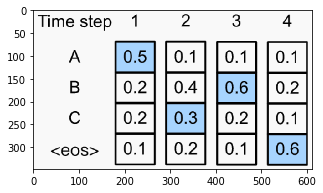

In [2]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
RNN = mpimg.imread('greedy_search.png')
plt.figure(figsize = (5,5))
imgplot = plt.imshow(RNN)
plt.show()

Optimal time step, but not optimal overall
$0.5 \times 0.4 \times 0.4 \times 0.6 = 0.048$

Not optimal time step, but optimal overall
$0.5 \times 0.3 \times 0.6 \times 0.6 = 0.054$


In [3]:
import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import pickle
from torch.autograd import Variable

CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")
print(device)

cuda


# Chatbot
recurrent sequence-to-sequence models
### 1. Load and preprocess the data



We are dealing with sequences of words, which cannot be directly mapped to a continuous vector space as we need for LSTMs. 

We will therefore create a mapping from each unique word in the dataset to an index value.

**VOC**: It creates both the forward mapping from words to indices and the reverse mapping from indices back to words, as well as a count of each word and a total word count. 

**(addWord)** The class's behavior includes a method to add a word to the vocabulary (addWord)

**(addSentence)** a method to add all words in a sentence at once (addSentence) 

**(trim)** a method to trim infrequently seen words (trim)

In [4]:
# Reserved word tokens

PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

class Voc:

    def __init__(self):        
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)

Before we can use the data, we have to perform some preprocessing.

#### 1.1 Convert Unicode strings to ASCII using unicodeToAscii. 

In [5]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

#### 1.2 Convert every letter to lowercase

In [6]:
# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

#### 1.2 Trim all non-letter characters except for basic punctuation (function normalizeString). 

improve training convergence, we filter out sentences with length greater than the MAX_LENGTH threshold (function filterPairs).

In [7]:
MAX_LENGTH = 10  # Maximum sentence length to consider

In [8]:
# Read query/response pairs and return a Voc object

def readVocs(datafile):
    print("Reading lines...")    
    # Read the file and split into lines
    lines = open(datafile, encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    voc = Voc()
    print(voc)
    return voc, pairs

# Boolean function returning True iff both sentences in a pair 'p' are under the MAX_LENGTH threshold

def filterPair(p):
    # Input sequences need to preserve the last word for EOS token
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

# Filter pairs using the filterPair predicate

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Using the functions defined above, return a populated voc object and pairs list

def loadPrepareData(datafile):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs

#### Load


In [9]:
# Load/Assemble Voc and pairs

datafile = 'data/chatDataset.txt'
voc, pairs = loadPrepareData(datafile)

# Print some pairs to validate

print("\npairs:")
for pair in pairs[:10]:
    print(pair)

Start preparing training data ...
Reading lines...
Read 221282 sentence pairs
Trimmed to 64271 sentence pairs
Counting words...
Counted words: 18008

pairs:
['there .', 'where ?']
['you have my word . as a gentleman', 'you re sweet .']
['hi .', 'looks like things worked out tonight huh ?']
['you know chastity ?', 'i believe we share an art instructor']
['have fun tonight ?', 'tons']
['well no . . .', 'then that s all you had to say .']
['then that s all you had to say .', 'but']
['but', 'you always been this selfish ?']
['do you listen to this crap ?', 'what crap ?']
['what good stuff ?', 'the real you .']


#### 1.3 Trim rarely-used words

As already mentioned, we will trim out **rarely-used** words from the vocabulary. This will help improve convergence during training, because with a lower-dimensional input feature space, it will be easier to estimate the probability model $P(y \mid x)$. We trim as a two-step process:

1. Trim words appearing fewer than MIN_COUNT times with the previously-given Voc.trim method.

2. Filter out all sentence pairs containing trimmed words.

In [10]:
MIN_COUNT = 3    # Minimum word count threshold for trimming

def trimRareWords(voc, pairs, MIN_COUNT):
    # Trim words used under the MIN_COUNT from the voc
    voc.trim(MIN_COUNT)
    # Filter out pairs with trimmed words
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs

#### Trim vocabulary and pairs

In [11]:
# Trim vocabulary and pairs
pairs = trimRareWords(voc, pairs, MIN_COUNT)

keep_words 7823 / 18005 = 0.4345
Trimmed from 64271 pairs to 53165, 0.8272 of total


### 2. Split dataset into testing and training pair sets

Let's split the dataset into the first ***45,000** pairs for training and the rest for testing:

In [12]:
testpairs = pairs[45000:]
pairs  = pairs[:45000]

### 3. Convert pairs to tensors

First, let's make tensors representing sentences in which we encode each sequence as a sequence of indices. The sequences should all be padded to to a length of MAX_LENGTH so that they are all the same size. 

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'trace']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


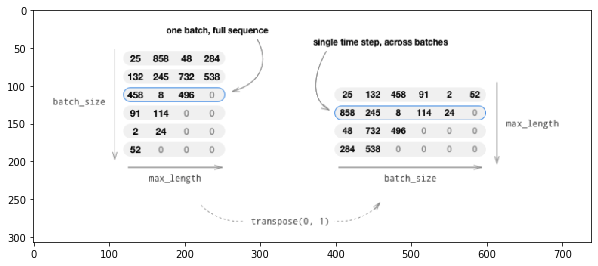

In [13]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
RNN = mpimg.imread('convertpairstotensor.png')
plt.figure(figsize = (10,10))
imgplot = plt.imshow(RNN)
plt.show()

**ZeroPadding** does the padding.

In [14]:
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]

def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

The **inputVar** function handles the process of **converting sentences to tensor**, ultimately creating a correctly shaped zero-padded tensor. It also returns a tensor of lengths for each of the sequences in the batch which will be passed to our decoder later.

In [15]:
# Return a padded input sequence tensor and the lengths of each original sequence
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths


The **outputVar** function performs a similar function to inputVar, but instead of returning a lengths tensor, it returns a **binary mask tensor and a maximum target sentence length**. The binary mask tensor has the same shape as the output target tensor, but every element that is a PAD_token is 0 and all others are 1.

In [16]:
# Return a padded target sequence tensor, a padding mask, and the max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.ByteTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

**batch2TrainData** simply takes a bunch of pairs and **returns the input and target tensors** using the aforementioned functions.

In [17]:
# Return all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len

In [18]:
# Example for validation
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

In [19]:
pair_batch = pairs[:5]
print(pair_batch)
pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
print(pair_batch)
print(target_variable)
print(mask)
print(max_target_len)

[['there .', 'where ?'], ['you have my word . as a gentleman', 'you re sweet .'], ['hi .', 'looks like things worked out tonight huh ?'], ['have fun tonight ?', 'tons'], ['well no . . .', 'then that s all you had to say .']]
[['you have my word . as a gentleman', 'you re sweet .'], ['well no . . .', 'then that s all you had to say .'], ['have fun tonight ?', 'tons'], ['there .', 'where ?'], ['hi .', 'looks like things worked out tonight huh ?']]
tensor([[  53,   25,   50,   96,    7],
        [2222,  192,    6,   12,   24],
        [   4,  387,    6,  130,    6],
        [   4,    4,    2,   66,  147],
        [   4,  158,    0,    2,   47],
        [   2,   76,    0,    0,    7],
        [   0,    4,    0,    0,   24],
        [   0,    2,    0,    0,    6],
        [   0,    0,    0,    0,    2]])
tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1],
        [1, 1, 0, 0, 1],
        [0, 1, 0, 0, 1],
        [0, 1,

### 4. Define models

Seq2Seq Model

The brains of our chatbot is a sequence-to-sequence (seq2seq) model. The goal of a seq2seq model is to take a **variable-length sequence as an input**, and return a **variable-length sequence as an output** using a **fixed-sized model**.

**Two separate recurrent neural nets**

1. One **RNN acts as an encoder**, which encodes a **variable length** input sequence to a fixed-length context vector. 

In theory, this context vector (the final hidden layer of the RNN) will contain semantic information about the query sentence that is input to the bot. 

2. The second RNN is a **decoder**, which takes an input word and the context vector, and returns a guess for the **next word in the sequence and a hidden state** to use in the next iteration.

## Encoder

The encoder RNN iterates through the input sentence **one token (e.g. word) at a time**, at each time step outputting an **“output” vector and a “hidden state”** vector. The **hidden state vector is then passed to the next time step**, while the **output vector is recorded**. The encoder transforms the context it saw at **each point in the sequence** into **a set of points** in a high-dimensional space, which the decoder will use to generate a meaningful output for the given task.



### bidirectional variant of the GRU: two independent RNNs

Using a bidirectional GRU will give us the advantage of encoding both past and future context.


1. one that is fed the input sequence in normal sequential order,
2. one that is fed the input sequence in reverse order

**Outputs** of each network are **summed** at each time step. 

Note that an **embedding layer** is used to encode our word indices in an **arbitrarily sized feature space**. For our models, this layer will map each word to a feature space of size hidden_size. When trained, these values should encode semantic similarity between similar meaning words.

Finally, if **passing a padded batch of sequences** to an RNN module, we must **pack and unpack** padding around the RNN pass using **nn.utils.rnn.pack_padded_sequence** and **nn.utils.rnn.pad_packed_sequence** respectively.



#### Computation Graph:

1) Convert word indexes to embeddings.

2) Pack padded batch of sequences for RNN module.

3) Forward pass through GRU.

4) Unpack padding.

5) Sum bidirectional GRU outputs.

6) Return output and final hidden state.

#### Inputs:

**input_seq**: batch of input sentences; shape=\ (max_length, batch_size)<br>
**input_lengths**: list of sentence lengths corresponding to each sentence in the batch; shape=\ (batch_size)<br>
**hidden**: hidden state; shape=\ (n_layers x num_directions, batch_size, hidden_size)

#### Outputs:

**outputs**: **output features** from the last hidden layer of the GRU (sum of bidirectional outputs); shape=\ (max_length, batch_size, hidden_size)<br>
**hidden**: updated hidden state from GRU; shape=\ (n_layers x num_directions, batch_size, hidden_size)

In [20]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding
        self.gru = nn.LSTM(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        '''
        an embedding layer is used to encode our word indices 
        in an arbitrarily sized feature space. 
        '''
        # 1. Convert word indexes to embeddings. nn.Embedding()
        embedded = self.embedding(input_seq)
        '''
         passing a padded batch of sequences to an RNN module, 
         we must pack and unpack padding around the RNN pass 
         using nn.utils.rnn.pack_padded_sequence and 
         nn.utils.rnn.pad_packed_sequence respectively.
        '''
        # 2. Pack padded batch of sequences for RNN module.
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths.cpu())
        # 3. Forward pass through GRU.
        outputs, hidden = self.gru(packed, hidden)
        # 4. Unpacked
        outputs, _ = nn.uti-ls.rnn.pad_packed_sequence(outputs)
        
        # 5. Sum bidirectional GRU outputs.
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        
        return outputs, hidden
    
    
    def init_hidden(self):
        # two for two directions
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

## Decoder


The decoder RNN generates the response sentence in a **token-by-token** fashion. It uses the encoder’s context vectors, and **internal hidden states** to generate the next word in the sequence.

It continues generating words until it outputs an EOS_token, representing the end of the sentence.

A common **problem** with a vanilla seq2seq decoder is that if we rely soley on the **context vector** to encode the entire input sequence’s meaning, it is likely that we will have **information loss**.

This is especially the case when dealing with **long input sequences**, greatly limiting the capability of our decoder.

**“Attention Mechanism”** that allows the **decoder to pay attention** to certain parts of the input sequence, rather than using the entire fixed context at every step.

attention is calculated using the **decoder’s current hidden state** and the **encoder’s outputs.**

The output attention weights have the same shape as the input sequence, allowing us to multiply them by the encoder outputs, giving us a **weighted sum which indicates the parts of encoder output to pay attention to**

### Attention weights

attention submodule

In [21]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        
    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def forward(self, hidden, encoder_outputs):
        
        attn_energies = self.dot_score(hidden, encoder_outputs)
        attn_energies = attn_energies.t()
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

For the decoder, we will manually feed our batch **one time step at a time**. This means that our embedded word tensor and GRU output will both have shape (1, batch_size, hidden_size).

**Computation Graph:**

1) Get embedding of current input word.

2) Forward through unidirectional GRU.

3) **Calculate attention weights** from the current GRU output from (2).

4) Multiply attention weights to encoder outputs to get new "weighted sum" context vector.

5) Concatenate weighted context vector and GRU output using Luong eq. 5.

6) Predict next word using Luong eq. 6 (without softmax).

7) Return output and final hidden state.

**Inputs:**

**input_step**: one time step (one word) of input sequence batch; shape=\ (1, batch_size) <br>
**last_hidden**: final hidden layer of GRU; shape=\ (n_layers x num_directions, batch_size, hidden_size)<br>
**encoder_outputs**: encoder model’s output; shape=\ (max_length, batch_size, hidden_size)

**Outputs:**

**output**: softmax normalized tensor giving probabilities of each word being the correct next word in the decoded sequence; shape=\ (batch_size, voc.num_words)<br>
**hidden**: final hidden state of GRU; shape=\ (n_layers x num_directions, batch_size, hidden_size)

### Decoder

In [22]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

       
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))#, bidirectional=True)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.attn = Attn(attn_model, hidden_size)
    
    def forward(self, input_step, last_hidden, encoder_outputs):
        # 1. Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # 2. Forward through unidirectional GRU.
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # 3. Calculate attention weights from the current GRU output from
        # 4. Multiply attention weights to encoder outputs to get new "weighted sum" context vector.
        attn_weights = self.attn(rnn_output, encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        # 5. Concatenate weighted context vector and GRU output using Luong eq. 5.
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # 6. Predict next word using Luong eq. 6 ("without softmax").
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # OUTPUT -> SOFTMAX! during teacher forcing NO SOFTMAX
        return output, hidden

### 5. Training procedure

**Masked loss**

Since we are dealing with batches of padded sequences, we cannot simply consider all elements of the tensor when calculating loss. We define maskNLLLoss to calculate our loss based on our decoder’s output tensor, the target tensor, and a **binary mask tensor describing the padding of the target tensor**. This loss function calculates the average negative log likelihood of the elements that correspond to a 1 in the mask tensor.

In [23]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

#### 5.1 Single training iteration

The train function contains the algorithm for a single training iteration (a single batch of inputs).

We will use a couple of **clever tricks to aid in convergence**:

* The first trick is using **teacher forcing**. This means that at some probability, set by **teacher_forcing_ratio**, we use the **current target word as the decoder’s next input** rather than using the decoder’s current guess. This technique acts as training wheels for the decoder, aiding in more efficient training. However, **teacher forcing can lead to model instability during inference**, as the decoder may not have a sufficient chance to truly craft its own output sequences during training. Thus, we must be mindful of how we are setting the teacher_forcing_ratio, and not be fooled by fast convergence.

* The second trick that we implement is **gradient clipping**. This is a commonly used technique for countering the “exploding gradient” problem. In essence, by clipping or thresholding gradients to a maximum value, we prevent the gradients from growing exponentially and either overflow (NaN), or overshoot steep cliffs in the cost function.

#### Sequence of Operations:

1) Forward pass entire input batch through encoder.

2) Initialize decoder inputs as SOS_token, and hidden state as the encoder's final hidden state.

3) Forward input batch sequence through decoder one time step at a time.

4) If **teacher forcing**: set **next decoder input as the current target**; else: set next decoder input as current decoder output.

5) Calculate and accumulate loss.

6) Perform backpropagation.

7) Clip gradients.

8) Update encoder and decoder model parameters.

#### Train function

In [24]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):

    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

  
    input_variable = input_variable.to(device)
    lengths = lengths.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)

    
    loss = 0
    print_losses = []
    n_totals = 0

    # 1. Forward pass entire input batch through encoder.
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # 2. Initialize decoder inputs as SOS_token, 
    # and hidden state as the encoder's final hidden state. 
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    
    decoder_hidden = encoder_hidden[:decoder.n_layers]
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    # TEACHER FORCING
    if use_teacher_forcing:
        # 3. Forward input batch sequence through decoder one time step at a time
        for t in range(max_target_len):
            
            # decoder_output -> SOFTMAX
            # BUT DO NOT USE IT AS DECODER_INPUT IN THE NEXT STEP
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            
            # CURRENT TARGET
            decoder_input = target_variable[t].view(1, -1)
            
            # 4. Calculate and accumulate loss.
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        # 3. Forward input batch sequence through decoder one time step at a time
        for t in range(max_target_len):
            
            # decoder_output -> SOFTMAX
            # BUT DO NOT USE IT AS DECODER_INPUT IN THE NEXT STEP
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            
            # choose the word from decoder_output with the highest SOFTMAX value.
            _, topi = decoder_output.topk(1)
            
            # CURRENT DECODER OUTPUT
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            
            decoder_input = decoder_input.to(device)
            
            # 4. Calculate and accumulate loss.
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    # 5. Perform backpropagation.
    loss.backward()
    
    # 6. Clip gradients.
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # 7. Update encoder and decoder model parameters
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

### 5.2 Full training procedure

The **trainIters** function is responsible for **running n_iterations of training** given the passed models, optimizers, data, etc. This function is quite self explanatory, as we have done the heavy lifting with the train function.

One thing to note is that when we save our model, we save a tarball containing the encoder and decoder **state_dicts** (parameters), the optimizers’ state_dicts, the loss, the iteration, etc. Saving the model in this way will give us the ultimate flexibility with the checkpoint. After loading a checkpoint, we will be able to use the model parameters to run inference, or we can continue training right where we left off.

In [25]:
max_target_len

9

In [26]:
def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, corpus_name, loadFilename):

    # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    losslist = []
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss

        
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0
            losslist.append(print_loss_avg)
        
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            print(directory)
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))
    return losslist


### 6. Evaluation function

After training a model, we want to be able to talk to the bot ourselves. First, we must **define how we want the model to decode the encoded input**.


### Beam search

Beam search is an **improved version of greedy search**. 

It has a hyperparameter named beam size, $k$. 

At time step 1, selecting $k$ tokens with the **highest conditional probabilities**. Each of them will be the **first token of $k$ candidate output sequences**, respectively. 

At each subsequent time step, **based on the $k$ candidate output sequences at the previous time step**, $k$ candidate output sequences has been selected with the highest conditional probabilities from $k|\gamma|$ possible choices.



#### Beam Decoder

The difference between greedy search and beam search is decoder function. Thus, greedy search function name is greedy_decode, and beam search function name is beam_decode.



In [27]:
class Sentence:
    def __init__(self, decoder_hidden, last_idx=SOS_token, sentence_idxes=[], sentence_scores=[]):
        if(len(sentence_idxes) != len(sentence_scores)):
            raise ValueError("length of indexes and scores should be the same")
        self.decoder_hidden = decoder_hidden
        self.last_idx = last_idx
        self.sentence_idxes =  sentence_idxes
        self.sentence_scores = sentence_scores

    def avgScore(self):
        if len(self.sentence_scores) == 0:
            raise ValueError("Calculate average score of sentence, but got no word")
        # return mean of sentence_score
        return sum(self.sentence_scores) / len(self.sentence_scores)

    def addTopk(self, topi, topv, decoder_hidden, beam_size, voc):
        topv = torch.log(topv)
        terminates, sentences = [], []
        for i in range(beam_size):
            if topi[0][i] == EOS_token:
                terminates.append(([voc.index2word[idx.item()] for idx in self.sentence_idxes] + ['<EOS>'],
                                   self.avgScore())) 
                continue
            idxes = self.sentence_idxes[:] 
            scores = self.sentence_scores[:] 
            idxes.append(topi[0][i])
            scores.append(topv[0][i])
            sentences.append(Sentence(decoder_hidden, topi[0][i], idxes, scores))
        return terminates, sentences

    def toWordScore(self, voc):
        
        words = []
        for i in range(len(self.sentence_idxes)):
            if self.sentence_idxes[i] == EOS_token:
                words.append('<EOS>')
            else:
                words.append(voc.index2word[self.sentence_idxes[i].item()])
       
        if self.sentence_idxes[-1] != EOS_token:
            words.append('<EOS>')
        return (words, self.avgScore())

    def __repr__(self):
        res = f"Sentence with indices {self.sentence_idxes} "
        res += f"and scores {self.sentence_scores}"
        return res
    

In [28]:
def beam_decode(decoder, decoder_hidden, encoder_outputs, voc, beam_size, max_length=MAX_LENGTH):
    terminal_sentences, prev_top_sentences, next_top_sentences = [], [], []
    prev_top_sentences.append(Sentence(decoder_hidden))
    for i in range(max_length):
        
        for sentence in prev_top_sentences:
            decoder_input = torch.LongTensor([[sentence.last_idx]])
            decoder_input = decoder_input.to(device)

            decoder_hidden = sentence.decoder_hidden
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(beam_size)
            term, top = sentence.addTopk(topi, topv, decoder_hidden, beam_size, voc)
            terminal_sentences.extend(term)
            next_top_sentences.extend(top)
           
        
        next_top_sentences.sort(key=lambda s: s.avgScore(), reverse=True)
        prev_top_sentences = next_top_sentences[:beam_size]
        next_top_sentences = []
        

    terminal_sentences += [sentence.toWordScore(voc) for sentence in prev_top_sentences]
    terminal_sentences.sort(key=lambda x: x[1], reverse=True)

    n = min(len(terminal_sentences), 15)
    return terminal_sentences[:n]

In [29]:
class BeamSearchDecoder(nn.Module):

    def __init__(self, encoder, decoder, voc, beam_size=10):
        super(BeamSearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.voc = voc
        self.beam_size = beam_size

    def forward(self, input_seq, input_length, max_length):
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        
        decoder_hidden = encoder_hidden[:self.decoder.n_layers]
        
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        sentences = beam_decode(self.decoder, decoder_hidden, encoder_outputs, self.voc, self.beam_size, max_length)
        
        
        all_tokens = [torch.tensor(self.voc.word2index.get(w, 0)) for w in sentences[0][0]]
        return all_tokens, None

    def __str__(self):
        res = f"BeamSearchDecoder with beam size {self.beam_size}"
        return res

#### Evaluating some text

Evaluating some text
Now that we have our decoding method defined, we can write functions for **evaluating a string input sentence.** 

The evaluate function manages the low-level process of handling the input sentence. 

1. We first format the sentence as an input batch of word indexes with batch_size==1. We do this by **converting the words of the sentence to their corresponding indexes**, and **transposing the dimensions to prepare the tensor** for our models. 

2. We also create **a lengths tensor which contains the length of our input sentence**. In this case, lengths is scalar because we are only evaluating one sentence at a time (batch_size==1). 

3. Next, we obtain the decoded response sentence tensor using our GreedySearchDecoder object (searcher). 

4. Finally, we convert the response’s indexes to words and return the list of decoded words.

evaluateInput acts as the user interface for our chatbot. When called, an input text field will spawn in which we can enter our query sentence. After typing our input sentence and pressing Enter, our text is normalized in the same way as our training data, and is ultimately fed to the evaluate function to obtain a decoded output sentence. We loop this process, so we can keep chatting with our bot until we enter either “q” or “quit”.

Finally, if a sentence is entered that contains a word that is not in the vocabulary, we handle this gracefully by printing an error message and prompting the user to enter another sentence.

In [30]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
  
    # 1. Convert the words of the sentence to their corresponding indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    
    # 2. Create a lengths tensor which contains the length of our input sentence.
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    
    # 1. Transpose the dimensions to prepare the tensor for our models.
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    
    input_batch = input_batch.to(device)
    lengths = lengths.to(device)
    
    # 3. Obtain the decoded response sentence tensor using our searcher = GreedySearchDecoder 
    tokens, scores = searcher(input_batch, lengths, max_length)
    
    # 4. Convert the response’s indexes to words and return the list of decoded words.
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            
            input_sentence = input('> ')
            
            if input_sentence == 'q' or input_sentence == 'quit': break
            
            input_sentence = normalizeString(input_sentence)
            
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")

### 7. Run Model
Finally, it is time to run our model!

Regardless of whether we want to train or test the chatbot model, we must **initialize the individual encoder and decoder models**. In the following block, we set our desired configurations, choose to start from scratch or set a checkpoint to load from, and build and initialize the models. Feel free to play with different model configurations to optimize performance.

In [31]:
# Load/Assemble Voc and pairs

datafile = 'data/chatDataset.txt'
voc, pairs = loadPrepareData(datafile)

# Print some pairs to validate

print("\npairs:")
for pair in pairs[:10]:
    print(pair)

Start preparing training data ...
Reading lines...
Read 221282 sentence pairs
Trimmed to 64271 sentence pairs
Counting words...
Counted words: 18008

pairs:
['there .', 'where ?']
['you have my word . as a gentleman', 'you re sweet .']
['hi .', 'looks like things worked out tonight huh ?']
['you know chastity ?', 'i believe we share an art instructor']
['have fun tonight ?', 'tons']
['well no . . .', 'then that s all you had to say .']
['then that s all you had to say .', 'but']
['but', 'you always been this selfish ?']
['do you listen to this crap ?', 'what crap ?']
['what good stuff ?', 'the real you .']


In [32]:
MAX_LENGTH = 10 
MIN_LENGTH = 3

In [33]:
# Trim vocabulary and pairs
pairs_ = trimRareWords(voc, pairs, MIN_COUNT)
print("len before trimming: ",len(pairs))
testpairs = pairs_[45000:]
pairs  = pairs_[:45000]
print("len after trimming: ",len(pairs))

keep_words 7823 / 18005 = 0.4345
Trimmed from 64271 pairs to 53165, 0.8272 of total
len before trimming:  64271
len after trimming:  45000


#### Define models

In [34]:
model_name = 'cb_model'
attn_model = 'dot'

hidden_size = 512
encoder_n_layers = 2
decoder_n_layers = 4
dropout = 0.5
batch_size = 256 
loadFilename = None

# 1. Embedding
embedding = nn.Embedding(voc.num_words, hidden_size)
# 2. Encoder
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
# 3. Decoder
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)

# Put everything to device
encoder = encoder.to(device)
decoder = decoder.to(device)

#### Optimizers

In [35]:
save_dir = 'content/'
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 6000
print_every = 10
save_every = 2000
loadFilename = None
corpus_name="Chat"

encoder.train()
decoder.train()

encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)

#### Training

In [ ]:
print("Starting Training!")
lossvalues = trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)

Starting Training!


### Plot graph

In [ ]:
import matplotlib.pyplot as plt
plt.plot(lossvalues)
plt.show()

## Bleu score Calculation

In [ ]:
# Set dropout layers to eval mode
encoder.eval()
decoder.eval()

# Initialize search module
from nltk.translate.bleu_score import sentence_bleu,corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction


searcher = BeamSearchDecoder(encoder, decoder, voc, 10)
gram1_bleu_score = []
gram2_bleu_score = []
# print(len(testpairs))
for i in range(0,len(testpairs),1):
    input_sentence = testpairs[i][0]
  
    reference = testpairs[i][1:]
    templist = []
    for k in range(len(reference)):
        if(reference[k]!=''):
            temp = reference[k].split(' ')
            templist.append(temp)
  
  
    input_sentence = normalizeString(input_sentence)
    output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
    output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
    chencherry = SmoothingFunction()
#   print(output_words)
#   print(templist)
    score1 = sentence_bleu(templist,output_words,weights=(1, 0, 0, 0) ,smoothing_function=chencherry.method1)
    score2 = sentence_bleu(templist,output_words,weights=(0.5, 0.5, 0, 0),smoothing_function=chencherry.method1) 
    gram1_bleu_score.append(score1)
    gram2_bleu_score.append(score2)
    if i%1000 == 0:
        print(i,sum(gram1_bleu_score)/len(gram1_bleu_score),sum(gram2_bleu_score)/len(gram2_bleu_score))
print("Total Bleu Score for 1 grams on testing pairs: ", sum(gram1_bleu_score)/len(gram1_bleu_score) )  
print("Total Bleu Score for 2 grams on testing pairs: ", sum(gram2_bleu_score)/len(gram2_bleu_score) )

In [ ]:
# Set dropout layers to eval mode
encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)

# Begin chatting (uncomment and run the following line to begin)
evaluateInput(encoder, decoder, searcher, voc)